# Comparing Molecules among Molecular Libraries

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import sys
sys.path.append('..')
sns.set(style='white', context='talk', font_scale=0.9)

#### Load the data

In [2]:
# Import the dictionary of dataframes with the rdkit molecules
file_rd_mols = './rdKit_db_molecules.obj'
with open(file_rd_mols, 'rb') as f:
    lig_datasets = pickle.load(f)

In [3]:
print(lig_datasets.keys())
lig_datasets['COCRYS'].head(3)

dict_keys(['COCRYS', 'CSAR', 'DUD', 'DEKOIS'])


,Activity,mol_rdk,sanitized,MW,num_atoms
Lig,,,,,
STU,active,<rdkit.Chem.rdchem.Mol object at 0x7fb767d08230>,True,465.533,35
ATP,active,<rdkit.Chem.rdchem.Mol object at 0x7fb7654b75f0>,True,503.150,31
PVB,active,<rdkit.Chem.rdchem.Mol object at 0x7fb76898e930>,True,259.700,18


## Using RDKit to evaluate some molecular descriptors

In [4]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
from rdkit.Chem.rdmolops import FastFindRings

for dataset in lig_datasets.values():
    # molecular weight
    dataset['MW'] = [round(Descriptors.MolWt(m), 3) for m in dataset['mol_rdk']]
    # number of heavy atoms
    dataset['num_atoms'] = [round(Chem.Lipinski.HeavyAtomCount(m), 3) for m in dataset['mol_rdk']]
    # Update ring properties
    mol_update = [FastFindRings(m) for m in dataset['mol_rdk']]
    # Get number of rotamers
    dataset['num_rot'] = [round(Chem.Lipinski.NumRotatableBonds(m), 3) for m in dataset['mol_rdk']]
    # Get number of rings
    dataset['num_rings'] = [round(rdMolDescriptors.CalcNumRings(m), 3) for m in dataset['mol_rdk']] 

### Plots

In [5]:
# Import some helper functions
from helper_functions_2 import violin_plot_helper, swarm_plot_helper

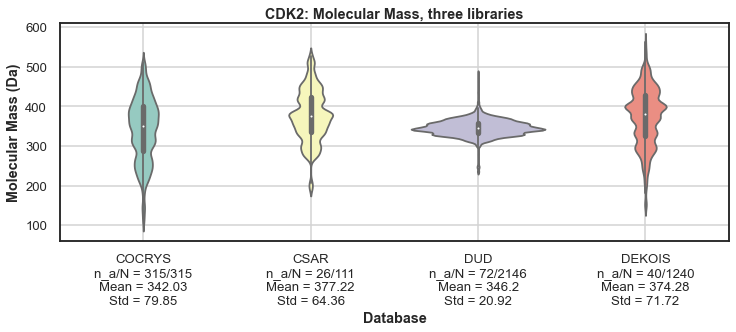

In [6]:
violin_plot_helper('MW', lig_datasets,               
    title = 'CDK2: Molecular Mass, three libraries', palette= 'Set3',
    xlabel= 'Database', ylabel = 'Molecular Mass (Da)', split_by_activity=False)

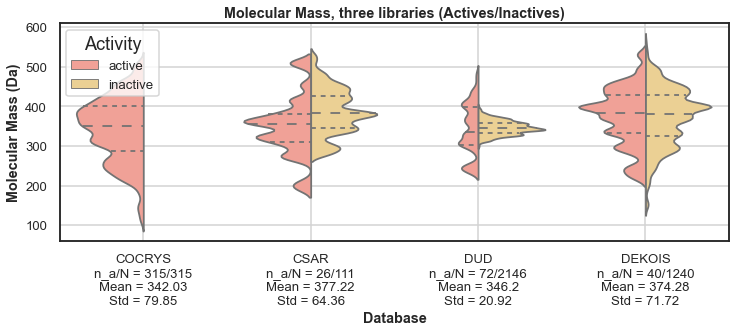

In [7]:
violin_plot_helper('MW', lig_datasets,
                   title = 'Molecular Mass, three libraries (Actives/Inactives)',
                   palette=['#FF9588', '#FAD585'], inner="quartile",
                   xlabel= 'Database', ylabel = 'Molecular Mass (Da)', split_by_activity=True)

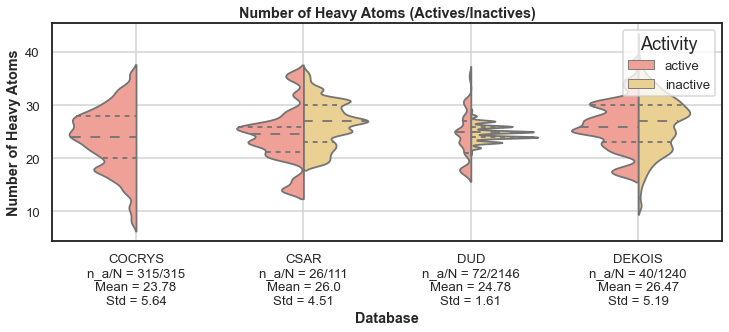

In [8]:
violin_plot_helper('num_atoms', lig_datasets,
                   title = 'Number of Heavy Atoms (Actives/Inactives)',
                   palette=['#FF9588', '#FAD585'], inner="quartile",
                   xlabel= 'Database', ylabel = 'Number of Heavy Atoms', split_by_activity=True)

## Merge the data frames (Molecular libraries)

In [9]:
# Get a dataframe for each library 
library_names = lig_datasets.keys()
dfs_list = []

# add a new column
for name in library_names:
    df = lig_datasets[name]
    # Add new column with its name
    df['library'] = name
    # Append to the df list
    dfs_list.append(df)

# Concat
df_all_mols = pd.concat(dfs_list, ignore_index=False).reset_index()
df_all_mols = df_all_mols.rename(columns={'index': 'name'})

In [10]:
## Compute fingerprints

In [11]:
%%time
# compute MACCS Fingerprints
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import DataStructs

def fps_to_array(fps, drop_constant_cols=True):
    """Convert a list of molecular fingerprints into a 
    numpy m*n array, where n = # molecules and n = # fps"""
    def fp2arr(fp):
        arr = np.zeros((0,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    X = np.asarray([fp2arr(fp) for fp in fps])
    if drop_constant_cols:
        X = pd.DataFrame(X)
        X = X.loc[:, X.var() != 0.0] 
    return X 


# Maccs Fingerprints
fps_all_maccs = [MACCSkeys.GenMACCSKeys(i) for i in df_all_mols.mol_rdk]
X_all_maccs = fps_to_array(fps_all_maccs)
print("MACCS Fps:", X_all_maccs.shape)
    
# Morgan Fingerprints
fps_all_morgan = [GetMorganFingerprintAsBitVect(i, radius=2) for i in df_all_mols.mol_rdk]
X_all_morgan = fps_to_array(fps_all_morgan)
print("Morgan Fps:", X_all_morgan.shape)

# RDKit Fingerprints
fps_all_rdk = [Chem.RDKFingerprint(i) for i in df_all_mols.mol_rdk]
X_all_rdk = fps_to_array(fps_all_rdk)
print("RDKit Fps:", X_all_rdk.shape)

MACCS Fps: (3812, 147)
Morgan Fps: (3812, 2047)
RDKit Fps: (3812, 2048)
CPU times: user 7.92 s, sys: 443 ms, total: 8.37 s
Wall time: 8.41 s


### Compare Molecules among datasets using MACCS Fingerprints

In [12]:
from helper_functions_2 import draw_matched_ligs, compare_lig_db

In [13]:
from modules.run_or_load_decorator import run_or_load

In [14]:
%%time
from itertools import combinations
from rdkit import DataStructs

'''The following list should have the same order of molecules, i.e., 
the same index should refers to the same molecule info in all list'''

# The following file will save the results
file_matched_mols = './df_repeated_mols_among_CSAR_DUD_DEKIOS_COCRYS.pkl'

@run_or_load
def find_redundand_molecules(filename, df):
    indices = df.index.values
    names = df.name.values
    mols = df.mol_rdk.values
    libraries = df.library.values
    fps = fps_all_morgan # We'll use Morgan fingerprints

    matched_molecules = []
    for j, k in combinations(indices, 2):
        fp_sim = DataStructs.FingerprintSimilarity(fps[j], fps[k],
                       metric=DataStructs.TanimotoSimilarity)
        if fp_sim == 1: # If similarity is equal to one
           matched_molecules.append( (names[j], names[k], libraries[j] + '_' + libraries[k]) )
    # Create a dataframe
    df_matched_mols = pd.DataFrame(matched_molecules, columns = ['mol1', 'mol2', 'libraries'])
    return df_matched_mols

df_matched_mols = find_redundand_molecules(filename=file_matched_mols, df=df_all_mols)
    
# ***********************************
# Sort by library and by mol column
# ***********************************
df_matched_mols.sort_values(['libraries', 'mol1'], inplace=True)

print('Number of repeated molecules among different or the same database:\n', df_matched_mols.shape[0])

File loaded: ./df_repeated_mols_among_CSAR_DUD_DEKIOS_COCRYS.pkl
Number of repeated molecules among different or the same database:
 538
CPU times: user 7.42 ms, sys: 0 ns, total: 7.42 ms
Wall time: 5.21 ms


#### How many molecules are repeated among a pair  of molecular libraries

In [15]:
df_matched_mols['libraries'].value_counts().sort_index()

COCRYS_COCRYS      2
COCRYS_CSAR        8
COCRYS_DEKOIS      1
COCRYS_DUD        17
CSAR_DUD           1
DEKOIS_DEKOIS      3
DUD_DEKOIS         3
DUD_DUD          503
Name: libraries, dtype: int64

#### How many molecules are decoys?

In [16]:
df_matched_mols.mol1.str.contains('^decoy').sum()

490

### Update Data frames by removing repeated molecules

In [17]:
set_to_drop = set()

col_mol1_unique = df_matched_mols.mol1.unique()
for mol1 in col_mol1_unique:
    rows = df_matched_mols[['mol2', 'libraries']][df_matched_mols.mol1 == mol1]
    # Select the library; the '$' character indicates the separation between name and library
    elements_to_drop = rows.apply(lambda x: x.values[0] + '$' + x.values[1].split('_')[1], axis=1).to_list()
    
    # Move the name to the set
    set_to_drop.update(elements_to_drop)
    
print('Number of molecules to drop', len(set_to_drop))

Number of molecules to drop 426


#### Helper function

In [18]:
# ******************************************
# Helper funtion to drop repeated molecules
# ******************************************
def drop_repeated_mols(df, mols_to_drop, temp_index):
    '''Drops rows from a given dataframe.'''
    temp_df = df.copy()
    temp_df['temp_index'] = temp_index
    temp_df = temp_df.set_index('temp_index')
    # drop molecules
    temp_df = temp_df.drop(mols_to_drop, axis=0)
    # reset index and drop temporal column
    temp_df = temp_df.reset_index().drop('temp_index', axis=1)
    return temp_df

### Update the original Data frames

In [19]:
# From the original MERGED dataset, create a temporal column with mol_name$library and set it as index
temp_index = df_all_mols[['name', 'library']].apply(lambda x: x.values[0] + '$' + x.values[1], axis=1).to_list()

#*********************************
# Update the original data frames
#*********************************

# Main DataFrame
df_all_mols = drop_repeated_mols(df_all_mols, set_to_drop, temp_index)
print(df_all_mols.shape)
# MACCS Fps
X_all_maccs = drop_repeated_mols(X_all_maccs, set_to_drop, temp_index)
print(X_all_maccs.shape)
# Morgan Fps
X_all_morgan = drop_repeated_mols(X_all_morgan, set_to_drop, temp_index)
# RDKit Fps
X_all_rdk = drop_repeated_mols(X_all_rdk, set_to_drop, temp_index)

(3386, 9)
(3386, 147)


## Dimensionality Reduction

### t-SNE
**If the number if features (descriptors) is too big, PCA could be performed before t-SNE to reduce the size of the dataset (the number of features).**


In [20]:
from sklearn.manifold import TSNE

In [35]:
# Create a dataframe with t.sne dimesions and other features
df_dim_project = df_all_mols.copy()[['library', 'name', 'mol_rdk', 'Activity', 'num_rings', 'num_atoms', 'num_rot']]

In [39]:
%%time
import os 

#**************
# Compute t-SNE
#**************
# Function to copute tSNE
def do_tsne(X_set, **kwargs):
    tsne = TSNE(**kwargs)
    tsne_dims = tsne.fit_transform(X_set)
    # append the tsne_dims
    dim_1 = tsne_dims[:, 0]
    dim_2 = tsne_dims[:, 1]
    return  (dim_1, dim_2)

@run_or_load
def _add_proj_cols_to_df(filename, df_to_update, descriptors_sets, 
                         projection_name, proj_func, **kwargs):
    df = df_to_update.copy()
    for desc_name, X_set in descriptors_sets.items():
        # Run the projection function
        dim_x, dim_y = proj_func(X_set, **kwargs)
        # Add the columns to the dataframe
        df[f'{desc_name}_{projection_name}_x'] = dim_x
        df[f'{desc_name}_{projection_name}_y'] = dim_y
    return df


CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 20.5 µs


In [42]:
# File to save
pkl_file = './df_COCRYS_CSAR_DUD_DEKOIS_with_Fingerprints_TSNE.obj'
# Create a dataframe with t.sne dimesions and other features
df_dim_project = df_all_mols.copy()[['library', 'name', 'mol_rdk', 'Activity', 
                                     'num_rings', 'num_atoms', 'num_rot']]
# Dictionary with descriptors sets
descriptors_sets = {'maccs': X_all_maccs, 'morgan': X_all_morgan, 'rdk': X_all_rdk}

# **************************************
# Compute TSNE on each descriptor set
# **************************************
df_dim_project = _add_proj_cols_to_df(pkl_file, df_dim_project, descriptors_sets,
                                      'tsne', do_tsne)

File loaded: ./df_COCRYS_CSAR_DUD_DEKOIS_with_Fingerprints_TSNE.obj


In [43]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, \
                            Span, CategoricalColorMapper, HoverTool
from bokeh.layouts import row, column
from bokeh.transform import factor_cmap, factor_mark
output_notebook()

Loading BokehJS ...

In [46]:
# Create the columndatasource
source_act = ColumnDataSource(data= df_dim_project[df_dim_project.Activity == 'active'].drop('mol_rdk', axis=1))
source_inact = ColumnDataSource(data= df_dim_project[df_dim_project.Activity == 'inactive'].drop('mol_rdk', axis=1))

# *******************************
# General parameters and values 
# *******************************
# Create the color and marker mappers
LIBRARIES = np.unique(source_act.data['library'])
ACTIVITY = np.unique(source_act.data['Activity'])
# Color mappers
col_library_map = factor_cmap('library', ['#20C55A', 'orange', '#FF5733', '#857CEA'], LIBRARIES)

# Vertical line
vline = Span(location=0, dimension='height', 
             line_color='black', line_width=2, line_alpha=0.5, line_dash='dashed')
# Horizontal line
hline = Span(location=0, dimension='width', 
             line_color='black', line_width=2, line_alpha=0.5, line_dash='dashed')
# HoverTool options
hover= HoverTool(tooltips=[ ('Name', '@name'), ('# Atoms', '@num_atoms'),('Library', '@library'),
          ('Activity', '@Activity')], names = ['actives'])
                            
def create_fig(desc, title='', kind_dr='tsne', legend_location='top_right', legend=False):
    ''' ColumnDataSources source_act  and source_inact must be instantiated'''
    f = figure(title=title, plot_width=450, plot_height=450,
          x_axis_label='First Dimension', y_axis_label='Second Dimension',
          tools='box_select,wheel_zoom,reset')
    # Add hovertool 
    
    f.renderers.extend([vline, hline])
    # Add glyphs
    # Plot inactives
    f_inac = f.circle(x= desc + f'_{kind_dr}_x', y= desc + f'_{kind_dr}_y', 
               color=col_library_map,
               nonselection_fill_color=col_library_map,
               nonselection_fill_alpha=0.05,
               size=4, alpha=0.15, line_width=0,
               muted_alpha=0.01,
               source=source_inact)

    # Plot actives
    f_act = f.triangle(x= desc + f'_{kind_dr}_x', y= desc + f'_{kind_dr}_y',
               color=col_library_map, legend_group='library',
               nonselection_fill_color=col_library_map,
               nonselection_fill_alpha=0.05,
               size=8, line_color='black', line_width=0.5, 
               source=source_act, name='actives')
    hover.renderers = [f_act]
#     f.add_tools(hover)
    
    # Styling
    f.title.text_font_size = '1.4em'
    f.axis.axis_label_text_font_size = '1.0em' # font size
    f.axis.axis_label_text_font_style = 'bold'
    f.title.align = 'center'
    f.axis.axis_line_width = 3
    f.axis.major_label_text_font_size = '12pt'
    if legend:
        f.legend.click_policy='mute'
        f.legend.location = legend_location
    else:
        f.legend.visible = False 
    return f
    
# ******************
# Create the figures
# ******************
maccs_plot = create_fig('maccs', title='t-SNE: MACCS Keys', legend=True)
morgan_plot = create_fig('morgan', title='t-SNE: Morgan Fps')
rdk_plot = create_fig('rdk', title='t-SNE: RDKit Fps')

layout = column(row(maccs_plot, morgan_plot), rdk_plot)

show(layout)